<p style="text-align:center">
    <a href="https://nbviewer.jupyter.org/github/twMr7/Python-Machine-Learning/blob/master/16-Hyperparameter_Search_and_Feature_Selection_with_Scikit.ipynb">
        Open In Jupyter nbviewer
        <img style="float: center;" src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" width="120" />
    </a>
</p>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twMr7/Python-Machine-Learning/blob/master/16-Hyperparameter_Search_and_Feature_Selection_with_Scikit.ipynb)

# 16. Hyperparameter Search and Feature Selection with Scikit

前一章的內容裡介紹了建立機器學習模型的基本流程，透過這些必要步驟可以建構出一個足供基準（baseline）評估的框架。 在實務上，模型需要調整不同的超參數來找到最適合的，減少輸入的特徵通常也有助於模型的泛化能力。

+ [**16.1 超參數搜尋 Hyperparameter Search**](#hyperparameter-search)
+ [**16.2 特徵選取 Feature Selection**](#feature-selection)
+ [**參考資料**](#references)

In [1]:
# 基本環境設定
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

import numpy as np
import pandas as pd
import seaborn as sns

### Breast Cancer Wisconsin 資料集

沿續前幾章所用的同一個資料集，僅有些許改變：
+ 檔案來源是已經加上欄位資訊的 .csv 檔。
+ 在特徵選取的單元，我們會希望觀察選取結果是那些欄位，所以回傳的訓練集和測試集不轉成 numpy 的 `ndarray`，直接是 pandas 的 `DataFrame` 或 `Series` 類型，scikit-learn 的工具照樣可以接受。


In [2]:
# 以下範例使用之前章節用過的 WDBC 資料集
from sklearn.model_selection import train_test_split

class WdbcDataset:
    def __init__(self):
        # 載入備份的 WDBC (Wisconsin Diagnostic Breast Cancer) 資料集
        my_wdbc_url = 'https://github.com/twMr7/Python-Machine-Learning/raw/master/dataset/BreastCancerWisconsin/wdbc.csv'
        # 這個備份的 csv 檔案已經有加上欄位標籤了
        self.df = pd.read_csv(my_wdbc_url, header=0)
        # 丟掉不需要的 "id" 欄位
        self.df.drop(columns=['id'], inplace=True)
        # 將 diagnosis 欄位良性與惡性的類別轉為 0 與 1
        self.df.loc[:,'diagnosis'] = self.df.loc[:,'diagnosis'].map({'B':0, 'M':1})
    
    def get_xy(self):
        # 取所有的 X
        X = self.df.drop(columns=['diagnosis'])
        # 取所有的 Y
        Y = self.df.loc[:,'diagnosis']
        # 資料分割 train:test = 9:1
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)
        # 回傳資料副本
        return X_train.copy(), X_test.copy(), Y_train.copy(), Y_test.copy()


In [3]:
# 取得訓練集與測試集
dsWdbc = WdbcDataset()
# NOTE: 回傳的維持是 DataFrame 與 Series 的類型
X_train, X_test, Y_train, Y_test = dsWdbc.get_xy()

# 顯示切割後的大小
print('X: train shape = {}, test shape = {}'.format(X_train.shape, X_test.shape))
print('Y: train shape = {}, test shape = {}'.format(Y_train.shape, Y_test.shape))

# 顯示切割後的類別分布
print('Train classes and counts:\n{}'.format(Y_train.value_counts()))
print('Test classes and counts:\n{}'.format(Y_test.value_counts()))

X: train shape = (512, 30), test shape = (57, 30)
Y: train shape = (512,), test shape = (57,)
Train classes and counts:
0    321
1    191
Name: diagnosis, dtype: int64
Test classes and counts:
0    36
1    21
Name: diagnosis, dtype: int64


<a id="hyperparameter-search"></a>

## 16.1 超參數搜尋 Hyperparameter Search

不同的學習演算法有不同的超參數。 同一個學習演算法，使用不同超參數組合訓練出來的模型，效能表現大多不相同。 先前提過交叉驗證的目的是為了找出適合的超參數，k-fold 的資料分割交互使用流程有工具方便自動處理，而超參數組合的數量是比 k-fold 更龐大的等級，我們同樣會希望有適合的工具來協助完成搜尋的流程。 Scikit-Learn 在 [`sklearn.model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) 模組提供了以下常用的工具：

+ [**`ParameterGrid`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) - 由超參數清單生成可供迭代的所有超參數組合。
+ [**`GridSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) - " *我全都要* " 的所有組合暴力搜尋，每組超參數都會使用交叉驗證的機制進行訓練。
+ [**`RandomizedSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) - 由超參數清單或機率分布中，隨機選取指定搜尋次數的組合。


In [4]:
from sklearn.model_selection import ParameterGrid

# hyperparameters for LogisticRegression
hyparam_list = [{
    'solver': ['newton-cg', 'sag', 'lbfgs'],
    'penalty': ['l2'],
    'max_iter': [300, 200, 100, 90, 80],
    'n_jobs': [-1]
}, {
    'solver': ['saga'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [300, 200, 100, 90, 80],
    'n_jobs': [-1]
}]

hyparam_grid = ParameterGrid(hyparam_list)
print('Type of ParameterGrid object =', type(hyparam_grid))
print('Number of combinations =', len(list(hyparam_grid)))
for n,p in enumerate(hyparam_grid):
    print('#{}: {}'.format(n, p))


Type of ParameterGrid object = <class 'sklearn.model_selection._search.ParameterGrid'>
Number of combinations = 30
#0: {'max_iter': 300, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg'}
#1: {'max_iter': 300, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'sag'}
#2: {'max_iter': 300, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}
#3: {'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg'}
#4: {'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'sag'}
#5: {'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}
#6: {'max_iter': 100, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg'}
#7: {'max_iter': 100, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'sag'}
#8: {'max_iter': 100, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}
#9: {'max_iter': 90, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg'}
#10: {'max_iter': 90, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'sag'}
#11: {'max_iter': 90, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}
#12: {'max_ite

### § 練習

請根據以上範例，練習運用 `ParameterGrid` 迭代所有的超參數組合，找出最適合模型的超參數。

1. 造出所需的超參數清單，用來生出 `ParameterGrid` 物件，對該物件迭代。
2. 迴圈裡建構你的 Pipeline 物件，使用 Pipeline.set_params() 方法，套用該次迭代的超參數。
3. 定義 metrics scores 。
4. 使用 Cross_Validate 交叉驗證。
5. 將每次的 score 記錄下來。
6. 迭代結束後找出最佳的 score 及對應的超參數。


### § 使用方便的 `GridSearchCV` 工具

Scikit-Learn 將繁雜的流程包裝成 `GridSearchCV` 跟 `RandomizedSearchCV` 類別，只需要設計好 Pipeline，準備好對應的超參數清單就可以開始搜尋了。


In [5]:
import time
import warnings
from sklearn.model_selection import (
    StratifiedKFold,
    ParameterGrid,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    recall_score,
    roc_auc_score
)

def bclass_hyparam_search(classifier, X, y, hyparams=list(), randomize=True):
    """Hyperparmaeter search for binary classification
    """
    combo_scores = {
        'roc_auc': make_scorer(roc_auc_score),
        'accuracy': make_scorer(accuracy_score),
        'sensitivity': make_scorer(recall_score, pos_label=1),
        'specificity': make_scorer(recall_score, pos_label=0)
    }

    if randomize: 
        len_of_grid = len(list(ParameterGrid(hyparams)))
        hypsearch = RandomizedSearchCV(
            classifier,
            param_distributions=hyparams,
            n_iter=int(len_of_grid * 0.25),
            scoring=combo_scores,
            refit='roc_auc',
            cv=StratifiedKFold(n_splits=10, shuffle=True),
            n_jobs=5,
            verbose=1
        )
    else:
        hypsearch = GridSearchCV(
            classifier,
            param_grid=hyparams,
            scoring=combo_scores,
            refit='roc_auc',
            cv=StratifiedKFold(n_splits=10, shuffle=True),
            n_jobs=5,
            verbose=1
        )
    # 參數搜尋很花時間，輸出開始與結束時間供參考
    print('[{}] hypsearch begin.'.format(time.strftime('%Y-%m-%d %H:%M:%S')), flush=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # 計時開始
        t_start = time.time()
        hypsearch.fit(X, y)
    print('[{}] hypsearch done in {:.3f} seconds.'.format(time.strftime('%Y-%m-%d %H:%M:%S'), time.time() - t_start))
    return hypsearch


### § 定義超參數清單

學習模型的演算法通常提供不少超參數可以調整，許多連續數值的超參數通常接受設定相當大的值域範圍。 這使得可以搜尋的空間相當大，我們不可能窮盡搜尋所有組合，一個常用的策略是：
1. 以該模型建議的預設值為中間基準值。
2. 先進行**大範圍搜尋**。 例如預設值為 1，先列出上下大範圍的清單如 [10000, 100, 1, 0.01, 0.0001]。
3. 由大範圍的搜尋結果，決定下次縮小的搜尋範圍。 例如偏向比預設值大的結果比較好，或許可搜尋 [10000, 5000, 1000, 500, 100]。
4. 收斂到可接受的分數時，將該組參數訓練的最佳模型進行測試集的測試，記錄測試結果。
5. **反覆縮小搜尋範圍**，直到滿意最佳的預測效能。

上述中，什麼範圍算是大或小，要由模型演算法對超參數的定義來決定。


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# the classifier
blrpipe = Pipeline(
    steps=[
        ('zscaler', StandardScaler()),
        ('blr', LogisticRegression())
    ]
)

# hyperparameter searching space for LogisticRegression
hyparam_list = [{
    'blr__solver': ['newton-cg', 'sag', 'lbfgs'],
    'blr__penalty': ['l2', 'none'],
    'blr__tol': [1e-3, 1e-4, 1e-5],
    'blr__C': [1e+2, 1.0, 1e-2],
    'blr__max_iter': [300, 100, 80],
    'blr__n_jobs': [-1]
}, {
    'blr__solver': ['saga'],
    'blr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'blr__tol': [1e-3, 1e-4, 1e-5],
    'blr__C': [1e+2, 1.0, 1e-2],
    'blr__max_iter': [300, 100, 80],
    'blr__n_jobs': [-1]
}]


In [7]:
# use grid search
blr_hsgrid = bclass_hyparam_search(blrpipe, X_train, Y_train, hyparams=hyparam_list, randomize=False)

# 搜尋完的結果都記錄在 GridSearchCV 物件的屬性中
print('Hyperparameter grid search result:\n  * best index: {}\n  * best parameters: {}\n  * best score: {:.3f}'.format(
    blr_hsgrid.best_index_, blr_hsgrid.best_params_, blr_hsgrid.best_score_))

# 輸出最佳得分，把 "mean_test" 字串換成 "validate" ，目的是為了記錄成日誌時，避免跟實際與測試集測試的 test score 搞混。
for k in ['mean_test_roc_auc','mean_test_accuracy','mean_test_sensitivity','mean_test_specificity']:
    print('  * {}: {:.3f}'.format(k.replace('mean_test','validate'), blr_hsgrid.cv_results_[k][blr_hsgrid.best_index_]))


[2021-05-05 22:40:14] hypsearch begin.
Fitting 10 folds for each of 270 candidates, totalling 2700 fits
[2021-05-05 22:40:45] hypsearch done in 30.795 seconds.
Hyperparameter grid search result:
  * best index: 210
  * best parameters: {'blr__C': 1.0, 'blr__max_iter': 100, 'blr__n_jobs': -1, 'blr__penalty': 'l1', 'blr__solver': 'saga', 'blr__tol': 0.001}
  * best score: 0.977
  * validate_roc_auc: 0.977
  * validate_accuracy: 0.981
  * validate_sensitivity: 0.963
  * validate_specificity: 0.991


### § 將結果輸出成檔案

超參數的搜尋通常也不會只做一次，實驗的過程要記錄下來，最重要的就是當次搜尋的最佳結果（`GridSearchCV.best_score_`）、最佳模型`GridSearchCV.best_estimator_`）、以及所有超參數組合的交叉驗證結果（`GridSearchCV.cv_results_`）。

`best_estimator_` 就是範例中使用 `Pipeline` 定義的模型，可以用 `pickle` 輸出成檔案。 `cv_results_` 是 `dict` 型態，非常適合轉成 `DataFrame` 觀察及輸出成 CSV 檔。 以下範例示範這樣的檔案操作。


In [8]:
import pickle

# use random search
blr_hsrand = bclass_hyparam_search(blrpipe, X_train, Y_train, hyparams=hyparam_list, randomize=True)

print('Hyperparameter random search result:\n  * best index: {}\n  * best parameters: {}\n  * best score: {:.3f}'.format(
    blr_hsrand.best_index_, blr_hsrand.best_params_, blr_hsrand.best_score_))
for k in ['mean_test_roc_auc','mean_test_accuracy','mean_test_sensitivity','mean_test_specificity']:
    print('  * {}: {:.3f}'.format(k.replace('mean_test','validate'), blr_hsrand.cv_results_[k][blr_hsrand.best_index_]))

# save the result and tag with current datetime
jobid = time.strftime('%Y%m%d-%H%M%S')

# log result to file
dfresult = pd.DataFrame(blr_hsrand.cv_results_)
log_file = 'blr-hypsearch-random-{}.csv'.format(jobid)
dfresult.to_csv(log_file, index=False)
print('Hyperparameter random search result logged to file: {}'.format(log_file))

# save the best model to file
model_file = 'blr-hypsearch-random-{}.pickle'.format(jobid)
with open(model_file, 'wb') as f:
    pickle.dump(blr_hsrand.best_estimator_, f, pickle.HIGHEST_PROTOCOL)
print('The best model pickled to file: {}'.format(model_file))


[2021-05-05 22:42:34] hypsearch begin.
Fitting 10 folds for each of 67 candidates, totalling 670 fits
[2021-05-05 22:42:41] hypsearch done in 6.837 seconds.
Hyperparameter random search result:
  * best index: 56
  * best parameters: {'blr__tol': 0.0001, 'blr__solver': 'saga', 'blr__penalty': 'l1', 'blr__n_jobs': -1, 'blr__max_iter': 80, 'blr__C': 1.0}
  * best score: 0.979
  * validate_roc_auc: 0.979
  * validate_accuracy: 0.983
  * validate_sensitivity: 0.964
  * validate_specificity: 0.994
Hyperparameter random search result logged to file: blr-hypsearch-random-20210505-224241.csv
The best model pickled to file: blr-hypsearch-random-20210505-224241.pickle


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

def rocauc_ci_bootstrap(classifier, X, y, n_samples=1000):
    """estimate the 95% confidence interval by bootstrapping the ROC AUC
    """
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()

    scores = []
    bootstrap = StratifiedShuffleSplit(n_splits=n_samples, test_size=0.8)
    # note that model is not re-trained
    for _, test_index in bootstrap.split(X, y):
        y_proba = classifier.predict_proba(X[test_index,:])[:,1]
        score = roc_auc_score(y[test_index], y_proba)
        scores.append(score)
    # the 95% CI
    return np.percentile(scores, (2.5, 97.5))

In [12]:
from sklearn.metrics import confusion_matrix

# Load the best model back and test it
with open(model_file, 'rb') as f:
    blr_hsrand_model = pickle.load(f)

# predict with test set
Y_predict = blr_hsrand_model.predict(X_test)

# confusion matrix
TN, FP, FN, TP = confusion_matrix(Y_test, Y_predict).ravel()
print('[Confusion Matrix]:\n  | TP: {} | FP: {} |\n  | FN: {} | TN: {} |\n'.format(TP, FP, FN, TN))

# sensitivity and specificity
sensitivity = recall_score(Y_test, Y_predict, pos_label=1)
print('[Testing Scores]:\n  * Sensitivity: {:.3f}'.format(sensitivity))
specificity = recall_score(Y_test, Y_predict, pos_label=0)
print('  * Specificity: {:.3f}'.format(specificity))
# accuracy and ROC AUC
accuracy = accuracy_score(Y_test, Y_predict)
print('  * Accuracy: {:.3f}'.format(accuracy))
rocauc = roc_auc_score(Y_test, blr_hsrand_model.predict_proba(X_test)[:,1])
rocauc_ci = rocauc_ci_bootstrap(blr_hsrand_model, X_test, Y_test)
print('  * ROC AUC : {:.3f}, 95% CI = ({:.3f}, {:.3f})'.format(rocauc, rocauc_ci[0], rocauc_ci[1]))


[Confusion Matrix]:
  | TP: 20 | FP: 0 |
  | FN: 1 | TN: 36 |

[Testing Scores]:
  * Sensitivity: 0.952
  * Specificity: 1.000
  * Accuracy: 0.982
  * ROC AUC : 1.000, 95% CI = (1.000, 1.000)


In [13]:
def plot_confusion_matrix(y, y_predict):
    """utility to plot confusion matrix
    """
    n_classes = np.unique(y)
    class_labels = ['Class'+str(int(n)) for n in reversed(n_classes)]
    confusion_table = pd.DataFrame(np.fliplr(np.rot90(confusion_matrix(y, y_predict))),
                                   index=class_labels,
                                   columns=class_labels)   
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(confusion_table, fmt='d', cmap='RdYlBu', alpha=0.9, vmin=0, annot=True, annot_kws={"fontsize": 14})    
    ax.set_title('True label', fontsize=14)
    ax.set_ylabel('Predicted label', fontsize=14)
    plt.show()


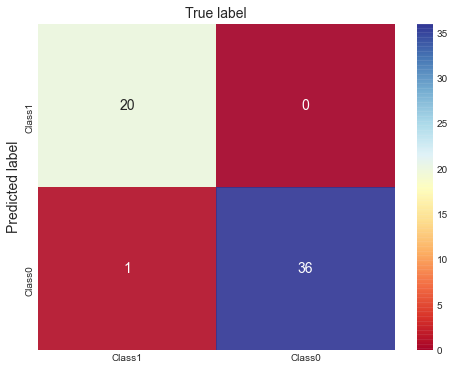

In [14]:
# 畫出二元分類的 confusion matrix
plot_confusion_matrix(Y_test, Y_predict)


<a id="feature-selection"></a>

## 16.2 特徵選取 Feature Selection

Scikit-Learn 在 [`sklearn.feature_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) 模組提供了以下常用的工具：

+ [**`chi2()`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) - 統計指標卡方檢定（$\chi^{2}$ test），適用於離散類別型的特徵。
+ [**`f_classif()`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html) - 統計上變異數分析（ANOVA）的 $F$ 檢定用於分類模型。
+ [**`f_regression()`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html) - 統計上變異數分析（ANOVA）的 $F$ 檢定用於回歸模型。
+ [**`mutual_info_classif()`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) - mutual information 用於分類模型。
+ [**`mutual_info_classif()`**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) - mutual information 用於回歸模型。


In [15]:
# 為了檢視特徵套用不同度量指標的結果，先做正規化
#zscale = lambda col: (col - col.mean()) / col.std()
minmax_scale = lambda col: (col - col.min()) / (col.max() - col.min())

X_train01 = X_train.apply(minmax_scale, axis=0)


In [16]:
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

wdbc_chi2, chi2_pvalue = chi2(X_train01, Y_train)
wdbc_fstat, fstat_pvalue = f_classif(X_train01, Y_train)
wdbc_mi = mutual_info_classif(X_train01, Y_train)


In [17]:
# 轉成 DataFrame 方便觀察
dfFeatureScore = pd.DataFrame({
    'χ²': wdbc_chi2,
    'χ² p-value': chi2_pvalue,
    'ANOVA f': wdbc_fstat,
    'ANOVA f p-value': fstat_pvalue,
    'Mutual Information': wdbc_mi
}, index=X_train01.columns)

dfFeatureScore

,χ²,χ² p-value,ANOVA f,ANOVA f p-value,Mutual Information
radius_mean,21.947031,2.802802e-06,563.290833,1.925850e-84,0.360890
texture_mean,6.700800,9.636964e-03,110.702638,1.457338e-23,0.102675
perimeter_mean,23.463141,1.273300e-06,607.719602,6.096234e-89,0.387383
area_mean,25.933519,3.533795e-07,496.769071,2.419594e-77,0.352781
smoothness_mean,3.578130,5.854502e-02,84.259148,1.080629e-18,0.081439
compactness_mean,19.000353,1.306943e-05,301.903645,1.853910e-53,0.210643
concavity_mean,41.869753,9.756018e-11,484.707036,5.263608e-76,0.378656
concave points_mean,49.877252,1.636713e-12,778.269397,1.085214e-104,0.444640
symmetry_mean,3.157095,7.559762e-02,72.970343,1.527566e-16,0.080062
fractal_dimension_mean,0.001261,9.716751e-01,0.016084,8.991298e-01,0.012007


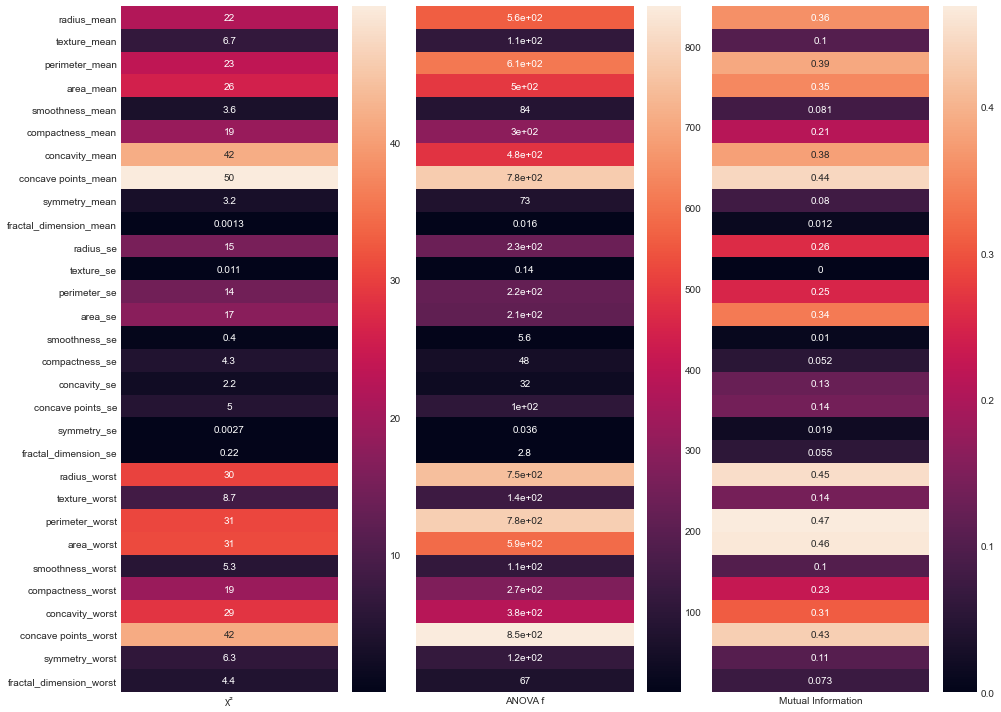

In [18]:
_, axs = plt.subplots(1, 3, figsize=(14,10))
sns.heatmap(dfFeatureScore[['χ²']], annot=True, yticklabels=True, ax=axs[0])
sns.heatmap(dfFeatureScore[['ANOVA f']], annot=True, yticklabels=False, ax=axs[1])
sns.heatmap(dfFeatureScore[['Mutual Information']], annot=True, yticklabels=False, ax=axs[2])

plt.tight_layout()
plt.show()


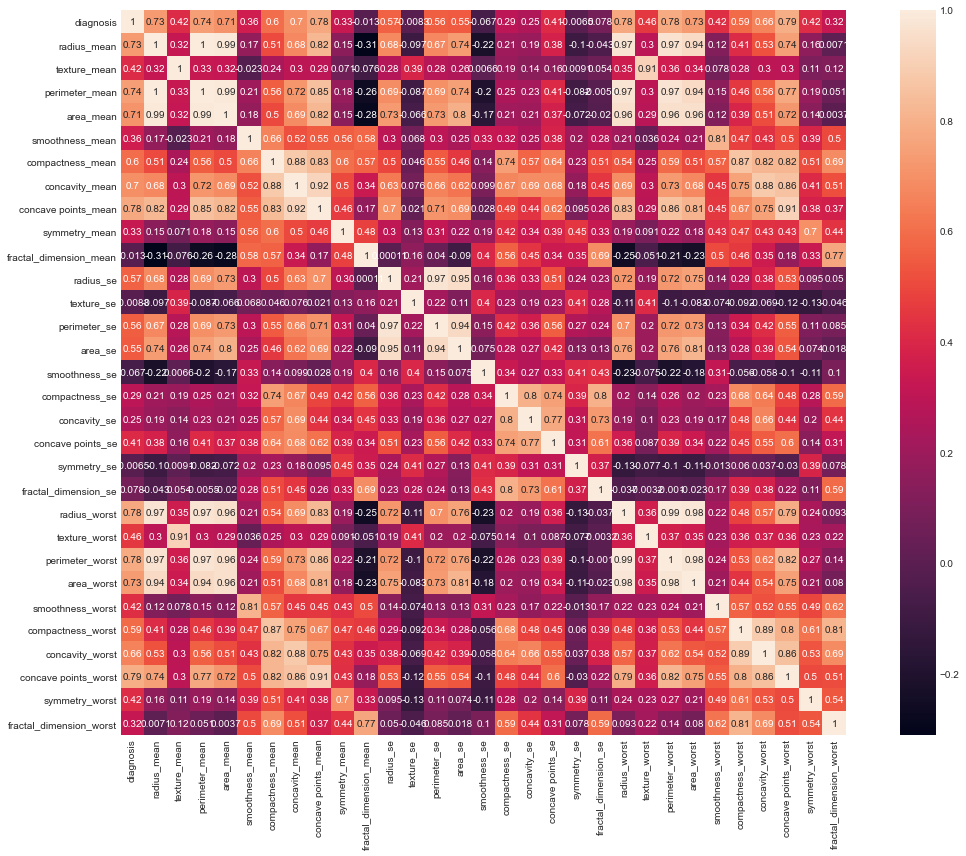

In [19]:
_, axcorr = plt.subplots(figsize=(16,12))
sns.heatmap(dsWdbc.df.corr(), annot=True, square=True, ax=axcorr)

plt.tight_layout()
plt.show()

In [20]:
chi2p_mask = chi2_pvalue < 1e-2

print('{} features selected by χ² p-value < 0.01:'.format(np.sum(chi2p_mask)))
list(X_train01.columns[chi2p_mask])

17 features selected by χ² p-value < 0.01:


['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst']

In [21]:
from sklearn.feature_selection import SelectFpr

chi2p_selectfpr = SelectFpr(chi2, alpha=0.01)
chi2p_selectfpr.fit(X_train01, Y_train)
chi2p_fpr_mask = chi2p_selectfpr.get_support()

print('{} features selected by χ² FPR test:'.format(np.sum(chi2p_fpr_mask)))
list(X_train01.columns[chi2p_fpr_mask])

17 features selected by χ² FPR test:


['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst']

In [22]:
from sklearn.feature_selection import SelectFdr

chi2p_selectfdr = SelectFdr(chi2, alpha=0.01)
chi2p_selectfdr.fit(X_train01, Y_train)
chi2p_fdr_mask = chi2p_selectfdr.get_support()

print('{} features selected by χ² FDR test:'.format(np.sum(chi2p_fdr_mask)))
list(X_train01.columns[chi2p_fdr_mask])

16 features selected by χ² FDR test:


['radius_mean',
 'perimeter_mean',
 'area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst']

In [23]:
from sklearn.feature_selection import SelectFwe

chi2p_selectfwe = SelectFwe(chi2, alpha=0.01)
chi2p_selectfwe.fit(X_train01, Y_train)
chi2p_fwe_mask = chi2p_selectfwe.get_support()

print('{} features selected by χ² FWE test:'.format(np.sum(chi2p_fwe_mask)))
list(X_train01.columns[chi2p_fwe_mask])

15 features selected by χ² FWE test:


['radius_mean',
 'perimeter_mean',
 'area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst']

In [24]:
k2select = 15
fstat_dec_index = np.flip(np.argsort(wdbc_fstat, kind='stable'))
print('Top {} ANOVA f-value:\n{}\n'.format(k2select, wdbc_fstat[fstat_dec_index[:k2select]]))
print('Top {} features selected from ANOVA f:'.format(k2select))
list(X_train01.columns[np.sort(fstat_dec_index[:k2select])])


Top 15 ANOVA f-value:
[849.53966402 783.86726519 778.26939726 752.32295849 607.71960229
 585.27655378 563.29083344 496.7690708  484.70703568 382.91417719
 301.90364456 273.72658119 232.4379389  219.90183404 209.32679101]

Top 15 features selected from ANOVA f:


['radius_mean',
 'perimeter_mean',
 'area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst']

In [25]:
from sklearn.feature_selection import SelectKBest

k2select = 15
fstat_selectk = SelectKBest(f_classif, k=k2select)
fstat_selectk.fit(X_train01, Y_train)
fstat_k_mask = fstat_selectk.get_support()

print('Top {} features selected from ANOVA f:'.format(k2select))
list(X_train01.columns[fstat_k_mask])

Top 15 features selected from ANOVA f:


['radius_mean',
 'perimeter_mean',
 'area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst']

In [26]:
k2select = 15
mi_dec_index = np.flip(np.argsort(wdbc_mi, kind='stable'))
print('Top {} Mutual Information:\n{}\n'.format(k2select, wdbc_mi[mi_dec_index[:k2select]]))
print('Top {} features selected from Mutual Information:'.format(k2select))
list(X_train01.columns[np.sort(mi_dec_index[:k2select])])


Top 15 Mutual Information:
[0.46866282 0.46494207 0.45070373 0.44463972 0.43270931 0.38738273
 0.37865642 0.3608904  0.35278057 0.33757956 0.30929263 0.25961094
 0.25232744 0.22784159 0.21064311]

Top 15 features selected from Mutual Information:


['radius_mean',
 'perimeter_mean',
 'area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst']

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector

# starting from a smaller filtered subset
mi15_index = np.sort(mi_dec_index[:k2select])
X_train_mi15 = X_train.iloc[:, mi15_index]

blrpipe = Pipeline(
    steps=[
        ('zscaler', StandardScaler()),
        ('blr', LogisticRegression())
    ]
)

hyparams = {
    'blr__solver': 'saga',
    'blr__penalty': 'l2',
    'blr__tol': 1e-5,
    'blr__C': 1.0,
    'blr__max_iter': 100,
    'blr__n_jobs': None
}

blrpipe.set_params(**hyparams)

seqfwd_selector = SequentialFeatureSelector(
    blrpipe,
    n_features_to_select=8,
    direction='backward',
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=10, shuffle=True),
    n_jobs=-1
)

seqfwd_selector.fit(X_train_mi15, Y_train)

seqfwd_mask = seqfwd_selector.get_support()
print('Sequential Forward Selected mask:\n{}\n'.format(seqfwd_mask))
print('Sequential Forward Selected features:')
list(X_train_mi15.columns[seqfwd_mask])


Sequential Forward Selected mask:
[False False  True  True  True  True  True False False  True False False
 False  True  True]

Sequential Forward Selected features:


['area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'radius_worst',
 'concavity_worst',
 'concave points_worst']

In [33]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# the classifier
blrfspipe = Pipeline(
    steps=[
        ('zscaler', StandardScaler()),
        ('fselectk', SelectKBest(mutual_info_classif)),
        ('blr', LogisticRegression())
    ]
)

# hyperparameter searching space for LogisticRegression
hypfs_list = [{
    'fselectk__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'blr__solver': ['newton-cg', 'sag', 'lbfgs'],
    'blr__penalty': ['l2', 'none'],
    'blr__tol': [1e-4],
    'blr__C': [1.0, 1e-1, 1e-2],
    'blr__max_iter': [120, 100, 80],
    'blr__n_jobs': [-1]
}, {
    'fselectk__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'blr__solver': ['saga'],
    'blr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'blr__tol': [1e-4],
    'blr__C': [1.0, 1e-1, 1e-2],
    'blr__max_iter': [120, 100, 80],
    'blr__n_jobs': [-1]
}]

# use grid search
blr_hypfs = bclass_hyparam_search(blrfspipe, X_train, Y_train, hyparams=hypfs_list, randomize=False)

print('Hyperparameter feature search result:\n  * best index: {}\n  * best parameters: {}\n  * best score: {:.3f}'.format(
    blr_hypfs.best_index_, blr_hypfs.best_params_, blr_hypfs.best_score_))
for k in ['mean_test_roc_auc','mean_test_accuracy','mean_test_sensitivity','mean_test_specificity']:
    print('  * {}: {:.3f}'.format(k.replace('mean_test','validate'), blr_hypfs.cv_results_[k][blr_hypfs.best_index_]))


[2021-05-05 23:35:02] hypsearch begin.
Fitting 10 folds for each of 900 candidates, totalling 9000 fits
[2021-05-05 23:39:33] hypsearch done in 270.973 seconds.
Hyperparameter feature search result:
  * best index: 37
  * best parameters: {'blr__C': 1.0, 'blr__max_iter': 120, 'blr__n_jobs': -1, 'blr__penalty': 'none', 'blr__solver': 'newton-cg', 'blr__tol': 0.0001, 'fselectk__k': 8}
  * best score: 0.960
  * validate_roc_auc: 0.960
  * validate_accuracy: 0.965
  * validate_sensitivity: 0.942
  * validate_specificity: 0.978


In [34]:
mi_mask = blr_hypfs.best_estimator_['fselectk'].get_support()

print('{} features selected from Mutual Information:'.format(np.sum(mi_mask)))
list(X_train.columns[mi_mask])

8 features selected from Mutual Information:


['radius_mean',
 'perimeter_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'concave points_worst']

<a id="references"></a>

## References:

1. Scikit-Learn, "*User Guide*", scikit-learn.org, [[link]](https://scikit-learn.org/stable/user_guide.html). 
2. Murphy, Kevin P. "*Machine learning: a probabilistic perspective*". MIT press, 2012.